In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import numpy as np

import sys
sys.path.insert(0, '/Dimensionality_reduction/')

from Deformation_gradient import get_eigenvalues
from trianglesolver import solve as tri_solve

from math import pi
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as Func
import torch.optim as optim


In [2]:
def get_side_lengths(triangle):
    side_length_1=np.linalg.norm(triangle[0]-triangle[1])
    side_length_2=np.linalg.norm(triangle[0]-triangle[2])
    side_length_3=np.linalg.norm(triangle[1]-triangle[2])
    return [side_length_1,side_length_2,side_length_3]




# The criteria to this is a bit hasty . Consider other criteria like triangular quality based on the 
# angles

def assign_angle_target_values(angles):
    if (180/pi)*max(angles) >= 170:
        return 0
    elif (180/pi)*min(angles)<= 7:
        return 1
    else:
        return 2
        
        
    

In [3]:
# Create random triangles
nb_of_triangles=50000
Y=np.empty([nb_of_triangles])
X=np.empty([nb_of_triangles,2])
for i in range(nb_of_triangles):
    triangle=np.random.normal(0,1,(3,2))
    #triangle=np.array([[-1,0],[1,0],[0,sqrt(3)]])
    triangle=np.hstack((triangle,[[0],[0],[0]]))
    
    #fig=plt.figure()
    #ax=fig.add_subplot(111)
    #plt.triplot(triangle[:,0],triangle[:,1])
    
    side_lengths=get_side_lengths(triangle)
    a,b,c,A,B,C=tri_solve(a=side_lengths[0],b=side_lengths[1],c=side_lengths[2])
    
    eig,F,U,rotation_angle =get_eigenvalues(triangle)
    X[i]=np.array(eig)
    target=assign_angle_target_values([A,B,C])
    Y[i]=np.array(target)


In [4]:
# Define dimensions of input, hidden and output for NN


input_dimension=2
output_dimension=2


# Convert to pytorch tennsors

x_tensor=torch.from_numpy(X).type(torch.FloatTensor)
y_tensor=torch.from_numpy(Y).type(torch.LongTensor)

# Convert to pytorch variables
x_variable=Variable(x_tensor,requires_grad=False)
y_variable=Variable(y_tensor,requires_grad=False)
y_variable


Variable containing:
 2
 0
 2
⋮ 
 2
 2
 1
[torch.LongTensor of size 50000]

In [5]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, n_hidden)   # hidden layer

        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)   # output layer
        self.fc3 = torch.nn.Linear(n_hidden, n_output)   # output layer


    def forward(self, x):
        x = Func.tanh(self.fc1(x))      # activation function for hidden layer
        #x = Func.tanh(self.fc2(x))
        x =self.fc3(x)


        return x

In [6]:
# Set hyperparameters #
net = Net(n_feature=2, n_hidden=5, n_output=3)     # define the network
print(net)  # net architecture

#optimizer=torch.optim.Adam(net.parameters(),lr=0.0001,weight_decay=.6)
optimizer = torch.optim.SGD(net.parameters(), lr=0.002,momentum=0.6)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotte

Net(
  (fc1): Linear(in_features=2, out_features=5)
  (fc2): Linear(in_features=5, out_features=5)
  (fc3): Linear(in_features=5, out_features=3)
)


In [7]:
# Train the network #

nb_of_epochs=2000

batch_size=100



for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        
        sum_loss+=loss
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    print("Epoch:",t,"Loss:",sum_loss.data[0])


Epoch: 0 Loss: 325.7652282714844
Epoch: 1 Loss: 224.17929077148438
Epoch: 2 Loss: 177.63037109375
Epoch: 3 Loss: 149.0987548828125
Epoch: 4 Loss: 131.4683074951172
Epoch: 5 Loss: 119.64368438720703
Epoch: 6 Loss: 111.16204071044922
Epoch: 7 Loss: 104.74771118164062
Epoch: 8 Loss: 99.6859130859375
Epoch: 9 Loss: 95.55333709716797
Epoch: 10 Loss: 92.0867919921875
Epoch: 11 Loss: 89.11469268798828
Epoch: 12 Loss: 86.52104187011719
Epoch: 13 Loss: 84.22486877441406
Epoch: 14 Loss: 82.16786193847656
Epoch: 15 Loss: 80.30690002441406
Epoch: 16 Loss: 78.60955047607422
Epoch: 17 Loss: 77.05066680908203
Epoch: 18 Loss: 75.61063385009766
Epoch: 19 Loss: 74.27381896972656
Epoch: 20 Loss: 73.02734375
Epoch: 21 Loss: 71.86090850830078
Epoch: 22 Loss: 70.76577758789062
Epoch: 23 Loss: 69.73462677001953
Epoch: 24 Loss: 68.7613296508789
Epoch: 25 Loss: 67.8406982421875
Epoch: 26 Loss: 66.96800231933594
Epoch: 27 Loss: 66.13957214355469
Epoch: 28 Loss: 65.35195922851562
Epoch: 29 Loss: 64.6024017333984

angles are:[138.7949490742164, 31.92629268233371, 9.278758243449927]
Variable containing:
-7.7315
 0.8502
 7.7371
[torch.FloatTensor of size 3]



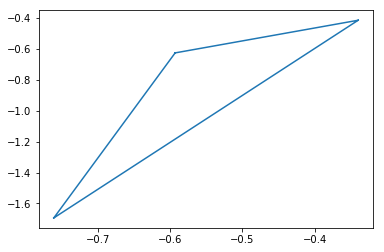

In [8]:
# Test triangle

triangle_test=np.random.normal(0,1,(3,2))
triangle_test=np.hstack((triangle_test,[[0],[0],[0]]))


plt.triplot(triangle_test[:,0],triangle_test[:,1])
   
side_lengths=get_side_lengths(triangle_test)
a,b,c,A,B,C=tri_solve(a=side_lengths[0],b=side_lengths[1],c=side_lengths[2])
    
eig,F,U,angle=get_eigenvalues(triangle_test)

side_lengths=get_side_lengths(triangle_test)
a,b,c,A,B,C=tri_solve(a=side_lengths[0],b=side_lengths[1],c=side_lengths[2])
X_test=Variable(torch.from_numpy(np.array(eig)).type(torch.FloatTensor))
Y_predict=net(X_test)
label=(Y_predict)



print("angles are:{0}" .format([(180/pi)*A,(180/pi)*B,(180/pi)*C]))
print(label)
index=Y_predict.data.numpy().argmax()

In [9]:
index

2